# COVID-19 Analysis - Argentina - 05/09/2020. (R Programming)

### Import the necessary libraries for the analysis.

In [25]:
library(tidyverse)
library(forcats)
library(repr)
library(fastDummies)
library(caret)


### Import the dataset.

In [3]:
covid <-  as.data.frame(read.csv('C:/Users/ramir/Desktop/DS/R/Covid19Casos.csv',stringsAsFactors = FALSE, encoding = 'UTF-8'))

# Dataset downloaded from http://datos.salud.gob.ar/dataset/covid-19-casos-registrados-en-la-republica-argentina

### Let's take a look at the dataset.

In [5]:
glimpse(covid)

Observations: 1,339,334
Variables: 25
$ id_evento_caso                   <int> 1000000, 1000002, 1000003, 1000005...
$ sexo                             <chr> "M", "M", "F", "F", "M", "M", "F",...
$ edad                             <int> 53, 21, 40, 58, 28, 26, 69, 73, 7,...
$ edad_años_meses                  <chr> "Años", "Años", "Años", "Años", "A...
$ residencia_pais_nombre           <chr> "Argentina", "Argentina", "Argenti...
$ residencia_provincia_nombre      <chr> "CABA", "Buenos Aires", "Córdoba",...
$ residencia_departamento_nombre   <chr> "SIN ESPECIFICAR", "La Matanza", "...
$ carga_provincia_nombre           <chr> "Buenos Aires", "Buenos Aires", "C...
$ fecha_inicio_sintomas            <chr> "", "", "2020-05-24", "", "2020-05...
$ fecha_apertura                   <chr> "2020-06-01", "2020-06-01", "2020-...
$ sepi_apertura                    <int> 23, 23, 23, 23, 23, 23, 23, 23, 23...
$ fecha_internacion                <chr> "", "", "", "", "", "", "", "", ""...
$ cuidado_inte

### Let's see the provinces of Argentina and test types.

In [6]:
unique(covid$residencia_provincia_nombre) 
unique(covid$clasificacion_resumen) 

[1] "CABA"                "Buenos Aires"        "Córdoba"            
 [4] "Mendoza"             "Formosa"             "Santa Fe"           
 [7] "San Luis"            "Entre Ríos"          "Tucumán"            
[10] "Chaco"               "Corrientes"          "Río Negro"          
[13] "La Pampa"            "Santa Cruz"          "Santiago del Estero"
[16] "Neuquén"             "SIN ESPECIFICAR"     "San Juan"           
[19] "Chubut"              "Catamarca"           "Tierra del Fuego"   
[22] "Misiones"            "Jujuy"               "La Rioja"           
[25] "Salta"

[1] "Descartado"     "Sospechoso"     "Confirmado"     "Sin Clasificar"

### We have to replace some values...

In [7]:
covid$clasificacion_resumen[covid$clasificacion_resumen == 'Descartado'] <- 'Negative'
covid$clasificacion_resumen[covid$clasificacion_resumen == 'Sospechoso'] <- 'Suspicious'
covid$clasificacion_resumen[covid$clasificacion_resumen == 'Confirmado'] <- 'Confirmed'
covid$clasificacion_resumen[covid$clasificacion_resumen == 'Sin Clasificar'] <- 'Unclassified'


### ... and change the dates format.

In [4]:
covid$fecha_apertura <- as.Date(covid$fecha_apertura)
covid$fecha_diagnostico <- as.Date(covid$fecha_diagnostico)
covid$fecha_inicio_sintomas <- as.Date(covid$fecha_inicio_sintomas, format = "%Y-%m-%d")
covid$ultima_actualizacion <- as.Date(covid$ultima_actualizacion, format = "%Y-%m-%d")


### Now let's see the quantity of tests per province.

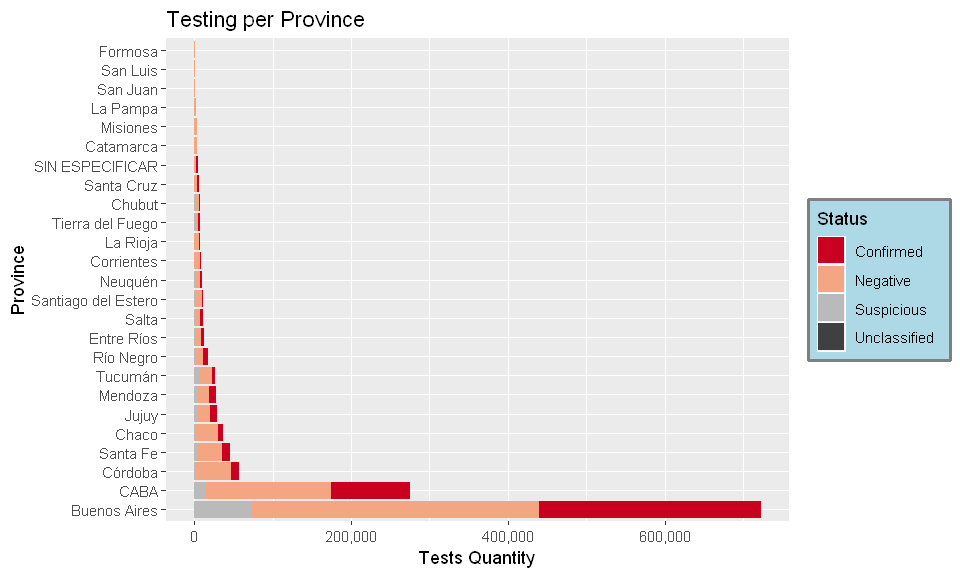

In [10]:
options(repr.plot.width=8, repr.plot.height=4.8)

ggplot(covid,aes(x = reorder(residencia_provincia_nombre,residencia_provincia_nombre,function(x)-length(x)),
                             fill=factor(clasificacion_resumen))) +
  geom_bar() +
  scale_fill_brewer(palette = "RdGy")+
  scale_y_continuous(labels = scales::comma, )+
  coord_flip() +
  ggtitle("Testing per Province")+
  xlab("Province") +
  ylab("Tests Quantity") +
  labs(fill = "Status") +
  theme(legend.background = element_rect(fill = "lightblue",colour = "grey50",size = 1))

### Perfect, now let's focus on the confirmed cases.

In [11]:
confirmed <- as_tibble(covid %>%
          filter(covid["clasificacion_resumen"] == "Confirmed") %>%
          count(residencia_provincia_nombre, sort = TRUE ))%>%
          rename(Quantity_of_cases = n)

In [12]:
head(confirmed)

residencia_provincia_nombre,Quantity_of_cases
Buenos Aires,282824
CABA,100271
Santa Fe,10806
Córdoba,10335
Jujuy,9547
Mendoza,8798


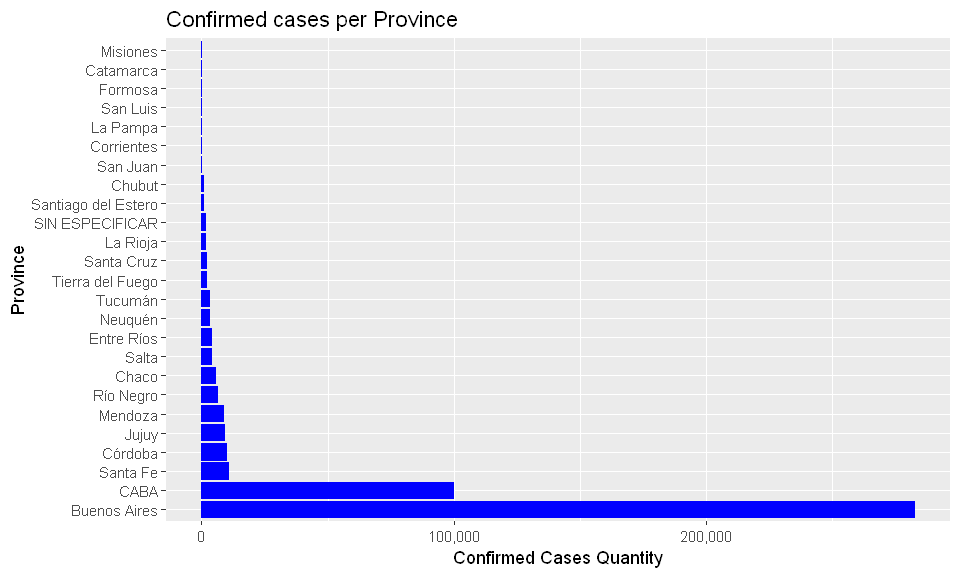

In [13]:
options(repr.plot.width=8, repr.plot.height=4.8)

ggplot(confirmed, aes(y= Quantity_of_cases, x = reorder(residencia_provincia_nombre, desc(Quantity_of_cases)))) +
 geom_col(fill='blue') +
 scale_y_continuous(labels = scales::comma)+
 coord_flip() +
 ggtitle("Confirmed cases per Province")+
 xlab("Province") +
 ylab("Confirmed Cases Quantity") 

### Now we have to take a look if there are any missing information and format the dates.

In [14]:
sum(is.na(covid$fecha_apertura))
sum(is.na(covid$clasificacion_resumen))

[1] 1

[1] 0

### Let's analyze the "NA" value.

In [15]:
na_value <- covid %>% filter(is.na(covid$fecha_apertura) == TRUE)
na_value

id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
672064,M,52,Años,Argentina,Buenos Aires,Florencio Varela,Buenos Aires,2020-05-29,NA,...,,NO,6,Público,Caso Descartado,Negative,6,2020-06-01,274,2020-09-04


#### It seems that the value does not follow the structure of the rest of the dataset. 

### Ok, let's see the evolution of cases through time. 

Warning message:
"Removed 1 rows containing non-finite values (stat_count)."

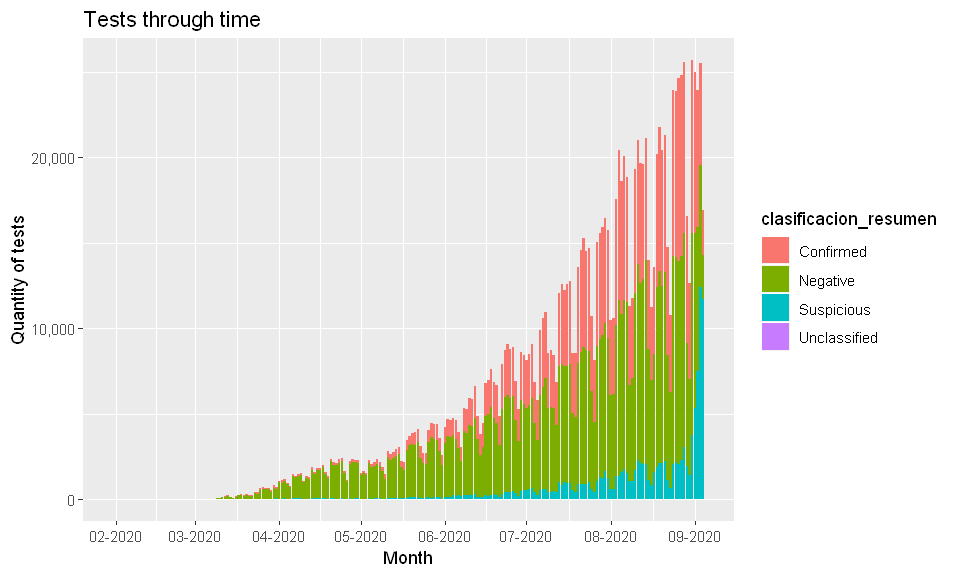

In [16]:
options(repr.plot.width=8, repr.plot.height=4.8)

ggplot(covid, aes(x = fecha_apertura ,fill = clasificacion_resumen ))+
  geom_bar() +
  scale_x_date(date_labels = "%m-%Y", date_break = "1 month" )+
  scale_y_continuous(labels = scales::comma)+
  ggtitle("Tests through time")+
  xlab("Month") +
  ylab("Quantity of tests") 

### Now let's remove the 'Suspicious' cases and take a look again. 

In [17]:
non_suspicious <- covid %>% filter(clasificacion_resumen != 'Suspicious') 

Warning message:
"Removed 1 rows containing non-finite values (stat_density)."

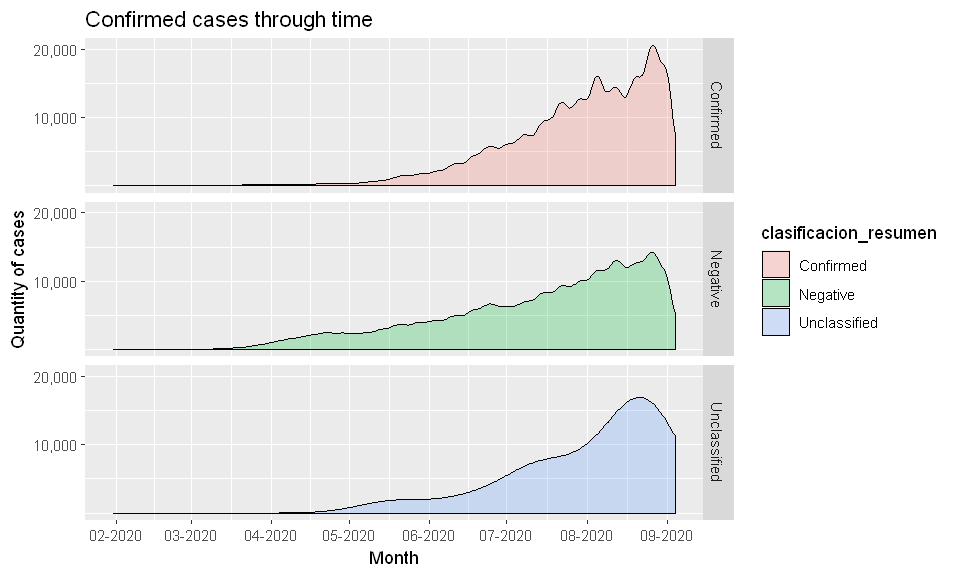

In [18]:
options(repr.plot.width=8, repr.plot.height=4.8)

ggplot(non_suspicious, aes(x = fecha_apertura ,fill = clasificacion_resumen))+
  geom_density(alpha = 0.25) +
  facet_grid(clasificacion_resumen ~.)+
  scale_x_date(date_labels = "%m-%Y", date_break = "1 month" )+
  scale_y_continuous(breaks = c(0.01, 0.02), labels = c("10,000", "20,000"))+
  ggtitle("Confirmed cases through time")+
  xlab("Month") +
  ylab("Quantity of cases") 

### Let's analyze now the quantity of deaths through time. 

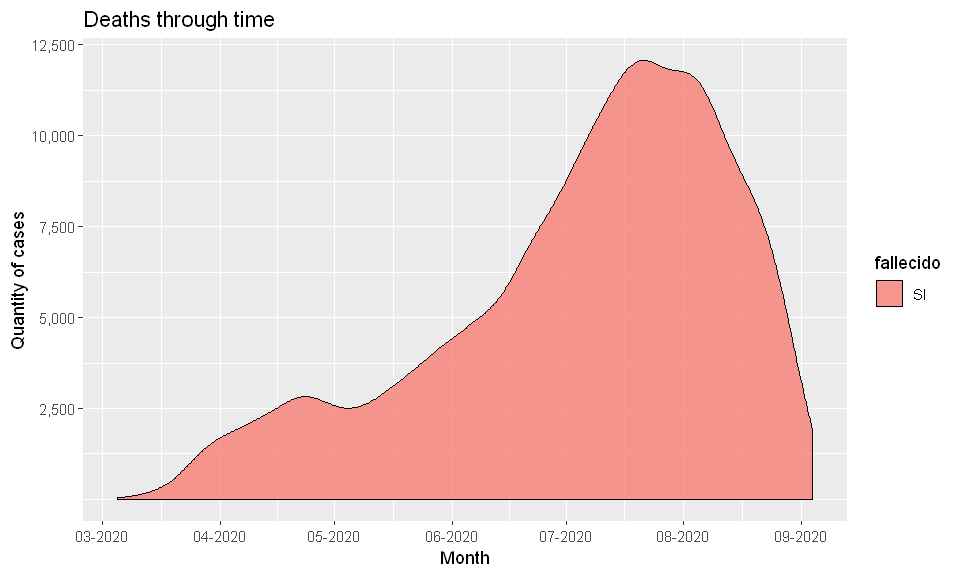

In [19]:
death <- covid %>% filter(fallecido == "SI")

ggplot(death, aes(x = fecha_apertura ,fill = fallecido))+
  geom_density(alpha = 0.75) +
  scale_x_date(date_labels = "%m-%Y", date_break = "1 month" )+
  scale_y_continuous(breaks = c(0.0025, 0.005,0.0075,0.01,0.0125), labels = c("2,500","5,000","7,500","10,000","12,500"))+
  ggtitle("Deaths through time")+
  xlab("Month") +
  ylab("Quantity of cases") 

### And finally, let's see the evolution of ventilators needed through time. 

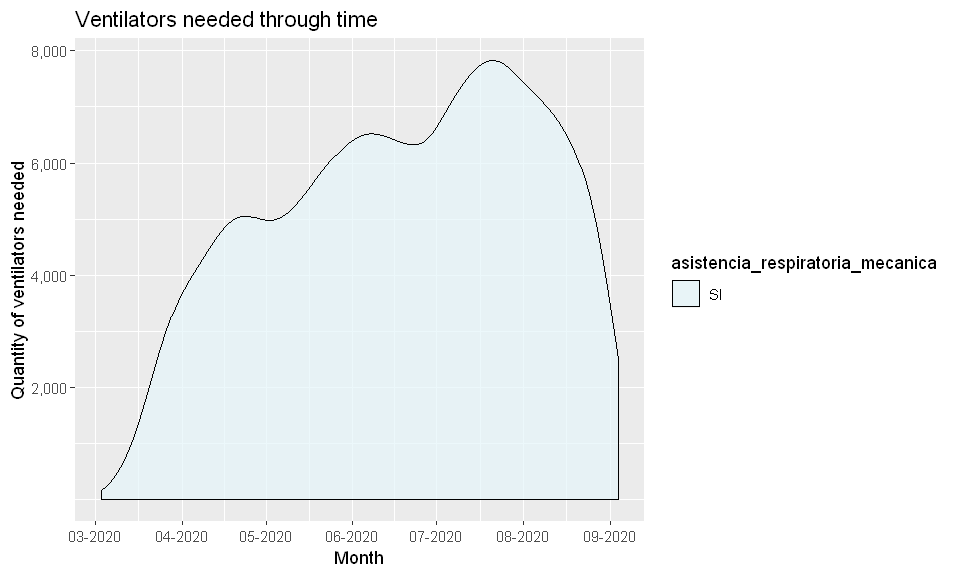

In [20]:
ventilator <- covid %>% filter(asistencia_respiratoria_mecanica == "SI")

ggplot(ventilator, aes(x = fecha_apertura ,fill = asistencia_respiratoria_mecanica))+
  geom_density(alpha = 0.75) +
  scale_x_date(date_labels = "%m-%Y", date_break = "1 month" )+
  scale_y_continuous(breaks = c(0.002, 0.004,0.006,0.008), labels = c("2,000","4,000","6,000","8,000"))+
  ggtitle("Ventilators needed through time")+
  xlab("Month") +
  ylab("Quantity of ventilators needed") +
  scale_fill_brewer(palette = "BuGn")

# Data Preparation

### Now we are going to run some classification models in order to predict if people with certain characteristics can survive COVID or if they will not. First of all, let's see if there are any missing values in the category "fallecido".

In [30]:
covid_analisis <- covid %>% select('fallecido','sexo','residencia_provincia_nombre','origen_financiamiento',
                                   'asistencia_respiratoria_mecanica','edad') 
glimpse(covid_analisis)

Observations: 1,339,334
Variables: 6
$ fallecido                        <chr> "NO", "NO", "NO", "NO", "NO", "NO"...
$ sexo                             <chr> "M", "M", "F", "F", "M", "M", "F",...
$ residencia_provincia_nombre      <chr> "CABA", "Buenos Aires", "Córdoba",...
$ origen_financiamiento            <chr> "Privado", "Público", "Privado", "...
$ asistencia_respiratoria_mecanica <chr> "NO", "NO", "NO", "NO", "NO", "NO"...
$ edad                             <int> 53, 21, 40, 58, 28, 26, 69, 73, 7,...


In [31]:
sum(is.na(covid_analisis$fallecido))
sum(is.na(covid_analisis$sexo))
sum(is.na(covid_analisis$residencia_provincia_nombre ))
sum(is.na(covid_analisis$origen_financiamiento))
sum(is.na(covid_analisis$asistencia_respiratoria_mecanica))
sum(is.na(covid_analisis$edad))


[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 1541

In [34]:
for(i in 1:ncol(covid_analisis)){
  covid_analisis[is.na(covid_analisis[,i]), i] <- mean(covid_analisis[,i], na.rm = TRUE)
}

Warning message in mean.default(covid_analisis[, i], na.rm = TRUE):
"argument is not numeric or logical: returning NA"Warning message in mean.default(covid_analisis[, i], na.rm = TRUE):
"argument is not numeric or logical: returning NA"Warning message in mean.default(covid_analisis[, i], na.rm = TRUE):
"argument is not numeric or logical: returning NA"Warning message in mean.default(covid_analisis[, i], na.rm = TRUE):
"argument is not numeric or logical: returning NA"Warning message in mean.default(covid_analisis[, i], na.rm = TRUE):
"argument is not numeric or logical: returning NA"

In [35]:
sum(is.na(covid_analisis$edad))


[1] 0

### Great, there are not missing values. Now let's create dummy variables.

In [58]:
covid_dummy <- dummy_cols(covid_analisis,  select_columns = c('fallecido','sexo','residencia_provincia_nombre','origen_financiamiento',
                                   'asistencia_respiratoria_mecanica') )

In [59]:
covid_dummy$edad <- as.integer(covid_dummy$edad)
glimpse(covid_dummy)

Observations: 1,339,334
Variables: 41
$ fallecido                                         <chr> "NO", "NO", "NO",...
$ sexo                                              <chr> "M", "M", "F", "F...
$ residencia_provincia_nombre                       <chr> "CABA", "Buenos A...
$ origen_financiamiento                             <chr> "Privado", "Públi...
$ asistencia_respiratoria_mecanica                  <chr> "NO", "NO", "NO",...
$ edad                                              <int> 53, 21, 40, 58, 2...
$ fallecido_NO                                      <int> 1, 1, 1, 1, 1, 1,...
$ fallecido_SI                                      <int> 0, 0, 0, 0, 0, 0,...
$ sexo_F                                            <int> 0, 0, 1, 1, 0, 0,...
$ sexo_M                                            <int> 1, 1, 0, 0, 1, 1,...
$ sexo_NR                                           <int> 0, 0, 0, 0, 0, 0,...
$ `residencia_provincia_nombre_Buenos Aires`        <int> 0, 1, 0, 0, 1, 0,...
$ residencia_p

Observations: 0
Variables: 0


### Perfect, now it's time to split the datase into train and test.

In [60]:
# set seed for reproducibility
set.seed(123)

# making a train index
train_index <- sample(c(TRUE, FALSE), replace = TRUE, size = nrow(covid_dummy), prob = c(0.2, 0.8))

# split the data according to the train index
train <- as.data.frame(covid_dummy[train_index, ])
test <- as.data.frame(covid_dummy[!train_index, ])

In [61]:
nrow(train)
nrow(test)
sum(nrow(test),nrow(train))

[1] 267988

[1] 1071346

[1] 1339334

In [49]:
logmod <- glm(target ~ . - id, data = training, family = binomial(link = 'logit'))

Warning message in storage.mode(x) <- "double":
"NAs introducidos por coerción"

ERROR: Error in qr.default(object): NA/NaN/Inf en llamada a una función externa (arg 1)
